# **Modelos de clasificación - Grupo03**

## **Authors**

- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310



## **Repositorio**

Esta práctica se ha llevado a cabo en este [repositorio de github](https://github.com/CLopMan/aprendizajeAutomatico-G03)

## **Introducción**

En este cuaderno se resolverá un problema similar. Las instancias de energía se han clasificado en "low" o "high" según si su valor es inferior o superior al valor del tercer cuartil. En este cuaderno trataremos de entrenar un modelo capaz de clasificar nuevas instancias en estas clases.

# **1. Transformación de datos**

El primer paso para el problema de clasificación es aplicar una transformación a la variable de salida. Es por ello que calculamos el tercer cuantil y transformamos la variable de salida respecto a este, asignandno el valor 0 para valores altos y 1 para valores bajos.

Esta asignación se debe a que el cálculo de la f1-score sólo es capaz de operar con clases numéricas, por lo que se decide hacer una representación numérica.

In [2]:
# Para ejecutar el cuaderno en drive
#from google.colab import drive
#import pandas as pd
#
#drive.mount('/content/drive')
#sotavento = pd.read_csv("/content/drive/MyDrive/wind_ava.csv") # acceder al csv en drive

In [3]:
import pandas as pd

sotavento = pd.read_csv("wind_ava.csv.gz", compression='gzip') # acceder al gz en local
#sotavento = raw_data.filter(regex='13$|energy|datetime') # eliminacion de instancias no referentes a Sotavento

Q3 = sotavento["energy"].quantile(0.75)
sotavento.insert(1, "energyTag", [0 for i in range(len(sotavento))])

cont = 0
for i, v in enumerate(sotavento["energy"]):
    if v < Q3:
        sotavento.loc[i, "energyTag"] = 1
        cont += 1

sotavento = sotavento.drop("energy", axis=1)

# **2. Clases desbalanceadas**

Si observamos los valores de energyTag, la nueva columna del dataframe que indica la clase de cada instancia, podemos ver que las clases están desbalanceadas.


Número de instancias 'low': 3561
Número de instancias 'high':1187


<Axes: ylabel='count'>

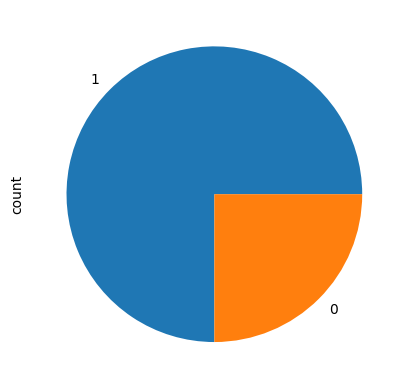

In [4]:
print(f"Número de instancias \'low\': {cont}\nNúmero de instancias \'high\':{len(sotavento) - cont}")

sotavento["energyTag"].value_counts().plot(kind="pie")

Es por ello que tenemos que tener en cuenta este desbalance. Posteriormente hablaremos sus efectos.

## **2.1. División entre train y test**
Para poder hacer los modelos de clasificación, primero, necesitaremos dividir el dataset entre las particiones de train y test.


In [5]:
from sklearn.model_selection import train_test_split

size = 0

res = pd.to_datetime(sotavento["datetime"], unit='ns').astype(str)

for ind, data in res.items():
  if data.startswith("2008") or data.startswith("2009"):
    size += 1

print("Hay", str(size), "instancias de 2008 y 2009")

# Se obtienen los datos
X = sotavento.drop(["energyTag", "datetime"], axis="columns")
Y = sotavento[["energyTag"]]

train, test = train_test_split(sotavento, test_size=size, shuffle=False)

X_train = train.drop(["energyTag", "datetime"], axis="columns")
Y_train = train[["energyTag"]]
X_test = test.drop(["energyTag", "datetime"], axis="columns")
Y_test = test[["energyTag"]]

Hay 1099 instancias de 2008 y 2009


## **2.2 Dummy**
Tras las particiones, crearemos un clasificacidor dummy, con el cual compararemos los resultados de nuestros modelos. De esta manera, podremos observar si hay alguna mejora con respecto a este.

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

# Generar datos de ejemplo
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, Y_train)


# Predecir con el conjunto de prueba
dummy_pred = dummy_classifier.predict(X_test)

# Calcular la precisión
f1 = f1_score(Y_test, dummy_pred)
print("Precisión del clasificador dummy:", f1)

Precisión del clasificador dummy: 0.851619644723093


# **3. Evaluación del modelo**
Para poder realizar modelos de clasificación, es necesario clarificar las métricas que usaremos, además de cómo realizaremos la evaluación inner y la evaluación outer.

## **3.1 Evaluación Inner**

Utilizaremos validación cruzada con k = 3 para la evaluación inner. Descartamos usar time series split debido a la nueva naturaleza del problema, es decir, una serie estática donde el tiempo no influye en los resultados.

## **3.2 Evaluación Outer**
Para la evaluación outer, hemos hecho un split dejando 2008 y 2009 para evaluar y el resto de años para entrenar. Esto se ve reflejado en el apartado 2.1.

## **3.3 Métricas de evaluación**

Para evaluar el modelo, emplearemos la métrica de *f1-score* debido a que se trata de un problema con clases desbalanceadas. Esta métrica no es sensible al desequilibrio de clases, ya que usa una media armónica. Es por esto y por la naturaleza de nuestro dataset, que usaremos esta métrica.



# **4. Modelos de clasificación**
En este apartado, aparecen los modelos de clasificación, con los que hemos hecho HPO para determinar los mejores hiperparámetros. Los modelos usados son los mismos que hemos usado en el apartado anterior, excepto la regresión.

Por útlimo, compararemos los modelos para determinar cuál de todos es el mejor.

## **4.1. K-folds**
Lo primero que deberemos hacer crear el objeto de K-folds, el cual usaremos en la evaluación inner de cada uno de los modelos. Debido a la amplia cantidad de datos con los que disponemos, creemos que realizar tres particiones es adecuado.

In [7]:
from sklearn.model_selection import KFold

kfold = KFold(3)

# Diccionarios donde guardaremos los datos para gráficos
f1_score = {}
train_time = {}

## **4.2. KNN**

El primer modelo a evaluar es el KNN, el cuál creemos que dará un buen rendimiento debido al algoritmo que usa. Este modelo tomará los n vecinos más cercanos para determinar la variable de salida.

In [8]:
# Knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from time import time


pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('knn', KNeighborsClassifier())
      ])

# Se crean los parametros
param_grid = {"knn__n_neighbors": list(range(10, 40, 2)),
              "knn__weights": ["uniform", "distance"],
              "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "knn__metric": ["euclidean", "manhattan", "chebyshev"]
              }

# Se realiza la HPO
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=3,
                    scoring="f1",
                    verbose=1,
                    n_jobs=-1)
start = time()
grid.fit(X_train, Y_train.values.ravel())
end = time()

print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")



f1_score["knn"] = grid.best_score_

print(f"f1-score: {grid.best_score_}")
print("Tiempo de entrenamiento:", str(round(end-start, 2)) + "s.")
train_time["knn"] = end - start

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


KeyboardInterrupt: 

Como podemos observar, la f1-score del KNN es un resultado muy bueno, y conseguido relativamente rápido. Además, mejora el clasificador dummy, por lo tanto observamos que este es un buen modelo.

## **4.3. Árbol de decisión**
El siguiente modelo a entrenar es el árbol de búsqueda, el cual pensamos que puede proporcionar buenos resultados, dada la naturaleza del problema y los resultados en el caso de la regresión.

In [ ]:


from sklearn.tree import DecisionTreeClassifier
import numpy as np

np.random.seed(100472092)
# Espacio de búsqueda

param_grid = {'max_depth': list(range(2, 24, 1)),
              'min_samples_split':list(range(30, 101, 3)),
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["best", "random"],
              "class_weight": ["balanced", None]}

grid = GridSearchCV(DecisionTreeClassifier(),
                         param_grid,
                         scoring='f1',
                         cv=kfold,
                         n_jobs=-1,
                         verbose=1)

start = time()
grid.fit(X=X_train, y=Y_train)
end = time()

print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")

f1_score["tree"] = grid.best_score_

print("f1:", str(grid.best_score_))
print("Tiempo de ejecución:", str(round(end - start, 2)) + "s.")
train_time["tree"] = end - start



Fitting 3 folds for each of 6336 candidates, totalling 19008 fits

Los mejores parámetros son:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 75, 'splitter': 'best'} 

f1: 0.9169094884180286
Tiempo de ejecución: 790.44s.


De manera similar al KNN, el árbol ha sacado muy buenos resultados, incluso mejores que el modelo anterior. Es también destacable que es mejor que el dummy y mucho más rápido que el KNN dado el número de fits entrenado en el corto tiempo.

## **4.4 SVM**
Usaremos un SVM para este apartado. De la misma manera que con el SVR, haremos la evaluación con tres modelos distintos, uno con cada tipo de kernel, para evitar combinaciones innecesarias y así ahorrar tiempo de entrenamiento.

In [ ]:
from sklearn.svm import SVC

kernels = ["linear", "poly", "rbf"]

# Hiperparámetros kernel lineal
param_grid_linear = {
              "svm__C": [1, 10, 100],
              }

# Hiperparámetros kernel poly
param_grid_poly = {
              "svm__C": [1, 10, 100],
              "svm__degree": list(range(1,4,1)),
              "svm__gamma": ["scale", "auto"],
              "svm__coef0": [0.0, 0.1]
              }

# Hiperparámetros kernel rbf
param_grid_rbf = {
              "svm__C": [1, 10, 100],
              "svm__gamma": ["scale", "auto"]
              }

for k in kernels:
  print("==========Kernel", k + "==========")

  # Se crea el regresor con kernel
  svm = SVC(kernel=k)

  # Se crea la pipeline
  pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm)
        ])

  # Se realiza la HPO
  match(k):
    case "linear":
      param_grid = param_grid_linear

    case "poly":
      param_grid = param_grid_poly

    case "rbf":
      param_grid = param_grid_rbf

  grid = GridSearchCV(pipe,
                      param_grid,
                      cv=kfold,
                      scoring="f1",
                      verbose=1,
                      n_jobs=-1)

  start = time()
  grid.fit(X_train, Y_train.values.ravel())
  end = time()

  print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")

  # Se obtiene el f1 del mejor modelo
  f1 = grid.best_score_

  f1_score["svm_"+k] = grid.best_score_
  print("F1_score:", str(f1))
  print("Tiempo de entrenamiento:", str(round(end-start,2)) + "s.")
  train_time["svm_"+k] = end - start

==========Kernel linear==========
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Los mejores parámetros son:
 {'svm__C': 1} 

F1_score: 0.8970416467725707
Tiempo de entrenamiento: 34.91s.
==========Kernel poly==========
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Los mejores parámetros son:
 {'svm__C': 1, 'svm__coef0': 0.1, 'svm__degree': 2, 'svm__gamma': 'scale'} 

F1_score: 0.9171918280799115
Tiempo de entrenamiento: 40.4s.
==========Kernel rbf==========
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Los mejores parámetros son:
 {'svm__C': 1, 'svm__gamma': 'scale'} 

F1_score: 0.9140890627868038
Tiempo de entrenamiento: 5.41s.


Vemos que el SVM es el peor de los tres, si bien mejora el dummy, no aporta un resultado tan alto como los otros modelos. Cabe destacar también el alto tiempo de entrenamiento dada la cantidad de fits del kernel lineal.

## **4.5 Modelo final**
Para elegir el mejor modelo, dibujaremos los errores y los tiempos de entrenamiento de cada uno de los modelos en dos diagramas de barras. Tras esto, elegiremos el mejor modelo de clasifcación.

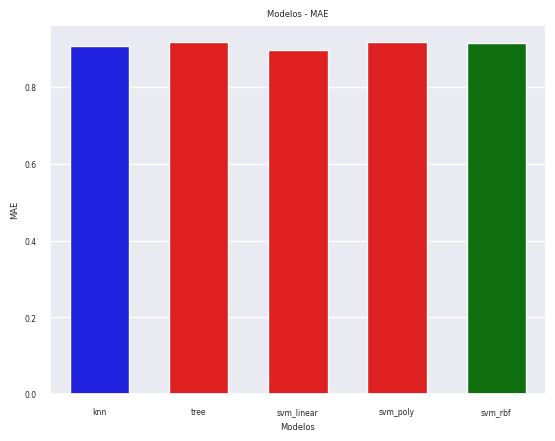

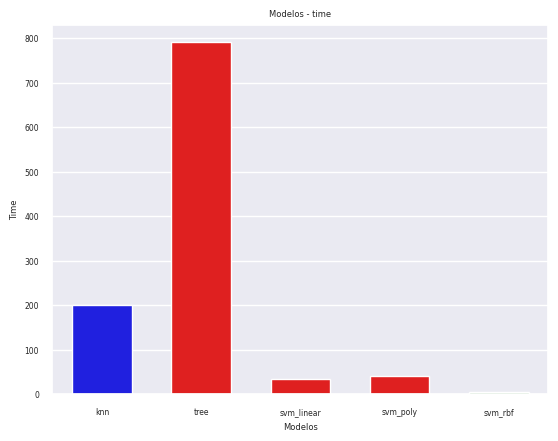

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Colores del diagrama
colores = ["blue", "red", "red", "red", "green"]
sns.set(font_scale=0.5)

# Valores del mae
titulos_mae = f1_score.keys()
valores_mae = f1_score.values()
titulos_time = train_time.keys()
valores_time = train_time.values()

# Plotear el mae
sns.barplot(x=titulos_mae, y=valores_mae, width=0.6, palette=colores, hue=titulos_mae, legend=False)

plt.xlabel("Modelos")
plt.ylabel("MAE")
plt.title("Modelos - MAE")

plt.show()

sns.barplot(x=titulos_time, y=valores_time, width=0.6, palette=colores, hue=titulos_time, legend=False)
plt.xlabel("Modelos")
plt.ylabel("Time")
plt.title("Modelos - time")
plt.show()

Como se puede observar, el mejor modelo con la *f1_score* es el árbol de decisión. Es por ello que construiremos el modelo final con este.

## **4.6 Modelo final y matriz de correlación**
Para ver la calidad del modelo final, usaremos la matriz de correlación. Como se puede observar, la score final es prácticamente de 0.9, acertando muchos *tue positive* y *true negative*.

Sin embargo, también observamos que las clases instanciadas como *high* tienen un alto número de *false positive*, lo cual nos hace inducir que el modelo no termina de clasificar correctamente las clases desbalanceadas.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4, min_samples_split=75, splitter='best')

best.fit(X_train, Y_train)
y_pred = best.predict(X_test)
score = f1_score(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
matrix = confusion_matrix(Y_test, y_pred, labels=best.classes_)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, y_pred), display_labels=best.classes_).plot()

print(score)
print(acc)
plt.show()

NameError: name 'DecisionTreeClassifier' is not defined